In [ ]:
# IMPORTS

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [ ]:
# EXTRACTING DATA
train_data = pd.read_csv('train.csv')
eval_data = pd.read_csv('test.csv')

x_train, x_test = train_test_split(train_data, test_size=0.2, random_state=42)

y_train = x_train['SalePrice']
x_train = x_train.drop(columns=['SalePrice'])

y_test = x_test['SalePrice']
x_test = x_test.drop(columns=['SalePrice'])

x_train = x_train.drop(columns=['Id'])
x_test = x_test.drop(columns=['Id'])




Mounted at /content/drive


In [ ]:
# PREPROCESSING

"""
    1. convert all the categorical data to numerical data
    2. impute missing values
    3. Norm the data
    4. PCA analysis
"""

print(f"shape of x_train: {x_train.shape} shape of x_test:  {x_test.shape}")

# 1. Convert categorical data to numerical using one-hot encoding
categorical_cols = x_train.select_dtypes(include=['object']).columns
x_train_encoded = pd.get_dummies(x_train, columns=categorical_cols, drop_first=True)
x_test_encoded = pd.get_dummies(x_test, columns=categorical_cols, drop_first=True)

x_train_encoded, x_test_encoded = x_train_encoded.align(x_test_encoded, join='left', axis=1)
x_test_encoded.fillna(0, inplace=True)

# 2. Impute missing values using median for numerical columns
for col in x_train_encoded.select_dtypes(include=['float64', 'int64']).columns:
    median_value = x_train_encoded[col].median()
    x_train_encoded[col].fillna(median_value, inplace=True)
    x_test_encoded[col].fillna(median_value, inplace=True)

print(f"shape of x_train_encoded: {x_train_encoded.shape} shape of x_test_encoded:  {x_test_encoded.shape}")

# 3. Normalize the data (Min-Max Scaling)
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_encoded)
x_test_scaled = scaler.transform(x_test_encoded)


pca = PCA(n_components=.30)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

# 4. PCA
print(f'IMPORTANT: shape of x_train_pca: {x_train_pca.shape} shape of x_test_pca:  {x_test_pca.shape} num_components: {pca.n_components_}')



shape of x_train: (1168, 79) shape of x_test:  (292, 79)
shape of x_train_encoded: (1168, 242) shape of x_test_encoded:  (292, 242)
IMPORTANT: shape of x_train_pca: (1168, 5) shape of x_test_pca:  (292, 5) num_components: 5


<ipython-input-59-fb453d8df208>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_train_encoded[col].fillna(median_value, inplace=True)
<ipython-input-59-fb453d8df208>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [ ]:
# EXPLAINING PCA
original_feature_names = x_train_encoded.columns
pca_components = pd.DataFrame(pca.components_, columns=original_feature_names)
explained_variance = pca.explained_variance_ratio_
print("Top features contributing to the first principal component:")
print(pca_components.iloc[0].nlargest(10))
print("Explained variance ratio for each component:")
print(explained_variance)

Top features contributing to the first principal component:
Foundation_PConc       0.281971
ExterQual_Gd           0.255269
Exterior1st_VinylSd    0.233187
Exterior2nd_VinylSd    0.229614
KitchenQual_Gd         0.226381
BsmtQual_Gd            0.221460
YearRemodAdd           0.174750
BsmtFinType1_GLQ       0.166482
GarageType_Attchd      0.145651
YearBuilt              0.122028
Name: 0, dtype: float64
Explained variance ratio for each component:
[0.15971872 0.06237027 0.04152981 0.03035932 0.02984492]


In [ ]:
"""
if you want your own data processing and cleaning you can start here
"""

In [ ]:
'''Temi's ANN'''
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Create datasets and data loaders
train_dataset = TensorDataset(torch.tensor(x_train_pca, dtype=torch.float32),
                              torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1))
test_dataset = TensorDataset(torch.tensor(x_test_pca, dtype=torch.float32),
                             torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the enhanced ANN model
class EnhancedHousePriceModel(nn.Module):
    def __init__(self, input_size):
        super(EnhancedHousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        x = self.fc5(x)
        return x

# Create the model, loss function, and optimizer
input_size = x_train_pca.shape[1]
model = EnhancedHousePriceModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Training loop with early stopping
num_epochs = 200
best_test_loss = float('inf')
patience = 10
epochs_without_improvement = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
    test_loss /= len(test_loader)

    # Scheduler step
    scheduler.step(test_loss)

    # Early stopping check
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    # Print progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss:.4f}')



Epoch [1/200], Test Loss: 39028058726.4000
Epoch [2/200], Test Loss: 39004589875.2000
Epoch [3/200], Test Loss: 38948567449.6000
Epoch [4/200], Test Loss: 38870551142.4000
Epoch [5/200], Test Loss: 38727736934.4000
Epoch [6/200], Test Loss: 38512248832.0000
Epoch [7/200], Test Loss: 38301566566.4000
Epoch [8/200], Test Loss: 37965573734.4000
Epoch [9/200], Test Loss: 37647270912.0000
Epoch [10/200], Test Loss: 37117491404.8000
Epoch [11/200], Test Loss: 36605390028.8000
Epoch [12/200], Test Loss: 35863705395.2000
Epoch [13/200], Test Loss: 35131784601.6000
Epoch [14/200], Test Loss: 34248103526.4000
Epoch [15/200], Test Loss: 33674100121.6000
Epoch [16/200], Test Loss: 32664744140.8000
Epoch [17/200], Test Loss: 31283275366.4000
Epoch [18/200], Test Loss: 30067304857.6000
Epoch [19/200], Test Loss: 29129940377.6000
Epoch [20/200], Test Loss: 28375393689.6000
Epoch [21/200], Test Loss: 27195332812.8000
Epoch [22/200], Test Loss: 25417690726.4000
Epoch [23/200], Test Loss: 24283018342.40

In [ ]:
y_pred = model(x_test_pca)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:

"""
Vincent's ANN model with first layer projecting to 256 neurons
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to tensors
x_train_tensor = torch.tensor(x_train_pca, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_pca, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create datasets and loaders
train_dataset = TensorDataset(x_train_tensor, y_train)
test_dataset = TensorDataset(x_test_tensor, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

class HousePriceModel(nn.Module):
    def __init__(self, input_size):
        super(HousePriceModel, self).__init__()
        self.block1 = nn.Sequential(
            nn.Linear(input_size, 256),  # Changed from 512 to 256
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.block2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.block3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.block4 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.block5 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return x

# Initialize model, loss function, and optimizer
input_size = x_train_pca.shape[1]
model = HousePriceModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
train_losses = []
test_losses = []
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluate the model
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Print progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch [50/200], Train Loss: 5286496269.8378, Test Loss: 6079252736.0000
Epoch [100/200], Train Loss: 2044279636.7568, Test Loss: 2186583827.2000
Epoch [150/200], Train Loss: 2091583797.6216, Test Loss: 2226297216.0000
Epoch [200/200], Train Loss: 1875612608.0000, Test Loss: 2189930284.8000


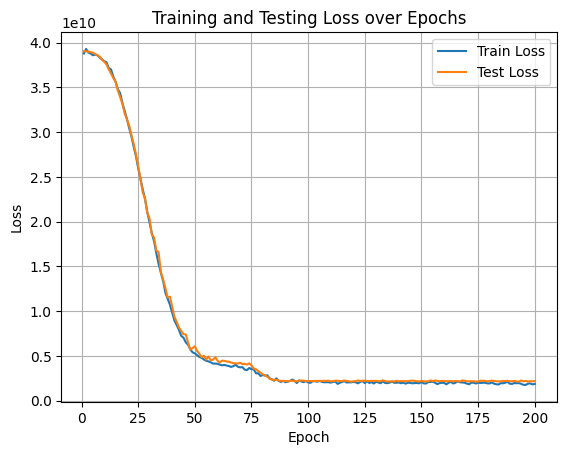

In [ ]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Vincent ANN model score
test_running_loss = 0.0
with torch.inference_mode():
      for batch_x, batch_y in test_loader:
          test_outputs = model(batch_x)
          loss = criterion(test_outputs, batch_y)
          test_running_loss += loss.item()

test_loss = test_running_loss / len(test_loader)

ANN_score = -np.log10((10*pca.n_components / 79)) * np.sqrt(test_loss)
print(f"ANN test_mse loss: {test_loss: .2f}")
print(f"ANN model score: {ANN_score: .2f}")

ANN test_mse loss:  2189930284.80
ANN model score:  66474.97


In [ ]:
#Temi ANN model score
# Evaluation and scoring
test_running_loss = 0.0
with torch.inference_mode():
    for batch_x, batch_y in test_loader:
        test_outputs = model(batch_x)
        loss = criterion(test_outputs, batch_y)
        test_running_loss += loss.item()

test_loss = test_running_loss / len(test_loader)

TEMI_score = np.log10((10*pca.n_components / 79)) * np.sqrt(test_loss)

# Print final scores
print(f'ANN test_mse loss: {test_loss:.2f}')
print(f'ANN model score: {TEMI_score:.2f}')


ANN test_mse loss: 2189930284.80
ANN model score: -66474.97


In [ ]:
# LightGBM Dataset Preparation
train_data = lgb.Dataset(x_train_scaled, label=y_train)
test_data = lgb.Dataset(x_test_scaled, label=y_test)

# Define parameter grid for GridSearchCV
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.05],
    'n_estimators': [100, 500, 1000],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [0, 0.1, 1.0]
}

# Initialize the LightGBM regressor
lgb_model = lgb.LGBMRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as scoring
    verbose=1,
    n_jobs=-1  # Use all processors
)

# Perform grid search
grid_search.fit(x_train_scaled, y_train)

# Best parameters and model
print(f"Best parameters found: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(x_test_scaled)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE of the optimized model: {rmse}')

NameError: name 'lgb' is not defined

In [ ]:
if(ANN_score <= TEMI_score):
    print(f"VINCENT model performs better with score of {ANN_score: .4f}")
else:
    print(f"TEMI model performs better with score of {TEMI_score: .4f}")

TEMI model performs better with score of -66474.9726


In [ ]:
1098042381 * (np.sqrt(79)/79) > ANN_score

True

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# 1. Convert categorical data to numerical using one-hot encoding
categorical_cols = eval_data.select_dtypes(include=['object']).columns
eval_encoded = pd.get_dummies(eval_data, columns=categorical_cols, drop_first=True)

# Align with the original training features (x_train_encoded)
eval_encoded = eval_encoded.reindex(columns=x_train_encoded.columns, fill_value=0)

# 2. Impute missing values using median for numerical columns
for col in eval_encoded.select_dtypes(include=['float64', 'int64']).columns:
    median_value = x_train_encoded[col].median()  # Use training medians for consistency
    eval_encoded[col].fillna(median_value, inplace=True)

# 3. Normalize the data using the trained scaler
eval_scaled = scaler.transform(eval_encoded)  # Use the same scaler from training

# 4. Apply the trained PCA for dimensionality reduction
eval_pca = pca.transform(eval_scaled)  # Use the trained PCA model

import torch
import numpy as np

# Assuming `eval_pca` is the PCA-transformed data and `model` is your trained model
eval_dataset = torch.utils.data.TensorDataset(torch.tensor(eval_pca, dtype=torch.float32))
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=32, shuffle=False)

# Initialize variables to store predictions
all_predictions = []

# Inference loop
with torch.inference_mode():
    for batch_x in eval_loader:
        batch_x = batch_x[0]  # Extract the data from the DataLoader
        outputs = model(batch_x)  # Get predictions from the model
        all_predictions.append(outputs.numpy())  # Collect predictions

# Concatenate predictions from all batches
all_predictions = np.concatenate(all_predictions, axis=0)

pd.DataFrame({'ID': np.arange(1461,2920), 'SalePrice': all_predictions.flatten()}).to_csv('submission5.csv', index=False)



<ipython-input-73-d3ae40cf6524>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eval_encoded[col].fillna(median_value, inplace=True)
<ipython-input-73-d3ae40cf6524>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr